In [1]:
%load_ext autoreload
%autoreload 2
%load_ext dotenv
%dotenv

In [2]:
import mlflow

### Load latest registered model


In [3]:
from mlflow import MlflowClient

client = MlflowClient()
latest_model_version = client.search_model_versions(
    "name='penguins'",
    max_results=1,
    order_by=["last_updated_timestamp DESC"],
)[0]
print(f"Model version: {latest_model_version.version}")

Model version: 27


In [4]:
payload1 = {
    "island": "Biscoe",
    "culmen_length_mm": 48.6,
    "culmen_depth_mm": 16.0,
    "flipper_length_mm": 230.0,
    "body_mass_g": 5800.0,
    "sex": "MALE",
}

payload2 = [
    {
        "island": "Biscoe",
        "culmen_length_mm": 48.6,
        "culmen_depth_mm": 16.0,
        "flipper_length_mm": 230.0,
        "body_mass_g": 5800.0,
        "sex": "MALE",
    },
    {
        "island": "Torgersen",
        "culmen_length_mm": 44.1,
        "culmen_depth_mm": 18.0,
        "flipper_length_mm": 210.0,
        "body_mass_g": 4000,
    },
    {
        "island": "Torgersen",
        "culmen_length_mm": 39.1,
        "culmen_depth_mm": 18.7,
        "flipper_length_mm": 181.0,
        "body_mass_g": 3750,
    },
]

In [5]:
model = mlflow.pyfunc.load_model(latest_model_version.source)

prediction = model.predict(payload2)
print(prediction)

Loading model context...
Model is ready to receive requests...
Handling request...
Transforming payload...
Making a prediction using the transformed payload...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Processing prediction received from the model...
[{'prediction': 'Gentoo', 'confidence': 0.9278518}, {'prediction': 'Gentoo', 'confidence': 0.506096}, {'prediction': 'Adelie', 'confidence': 0.9875431}]


### Deploying the model locally

```
$ mlflow models serve -m models:/penguins/42 -p 9876 --no-conda
```

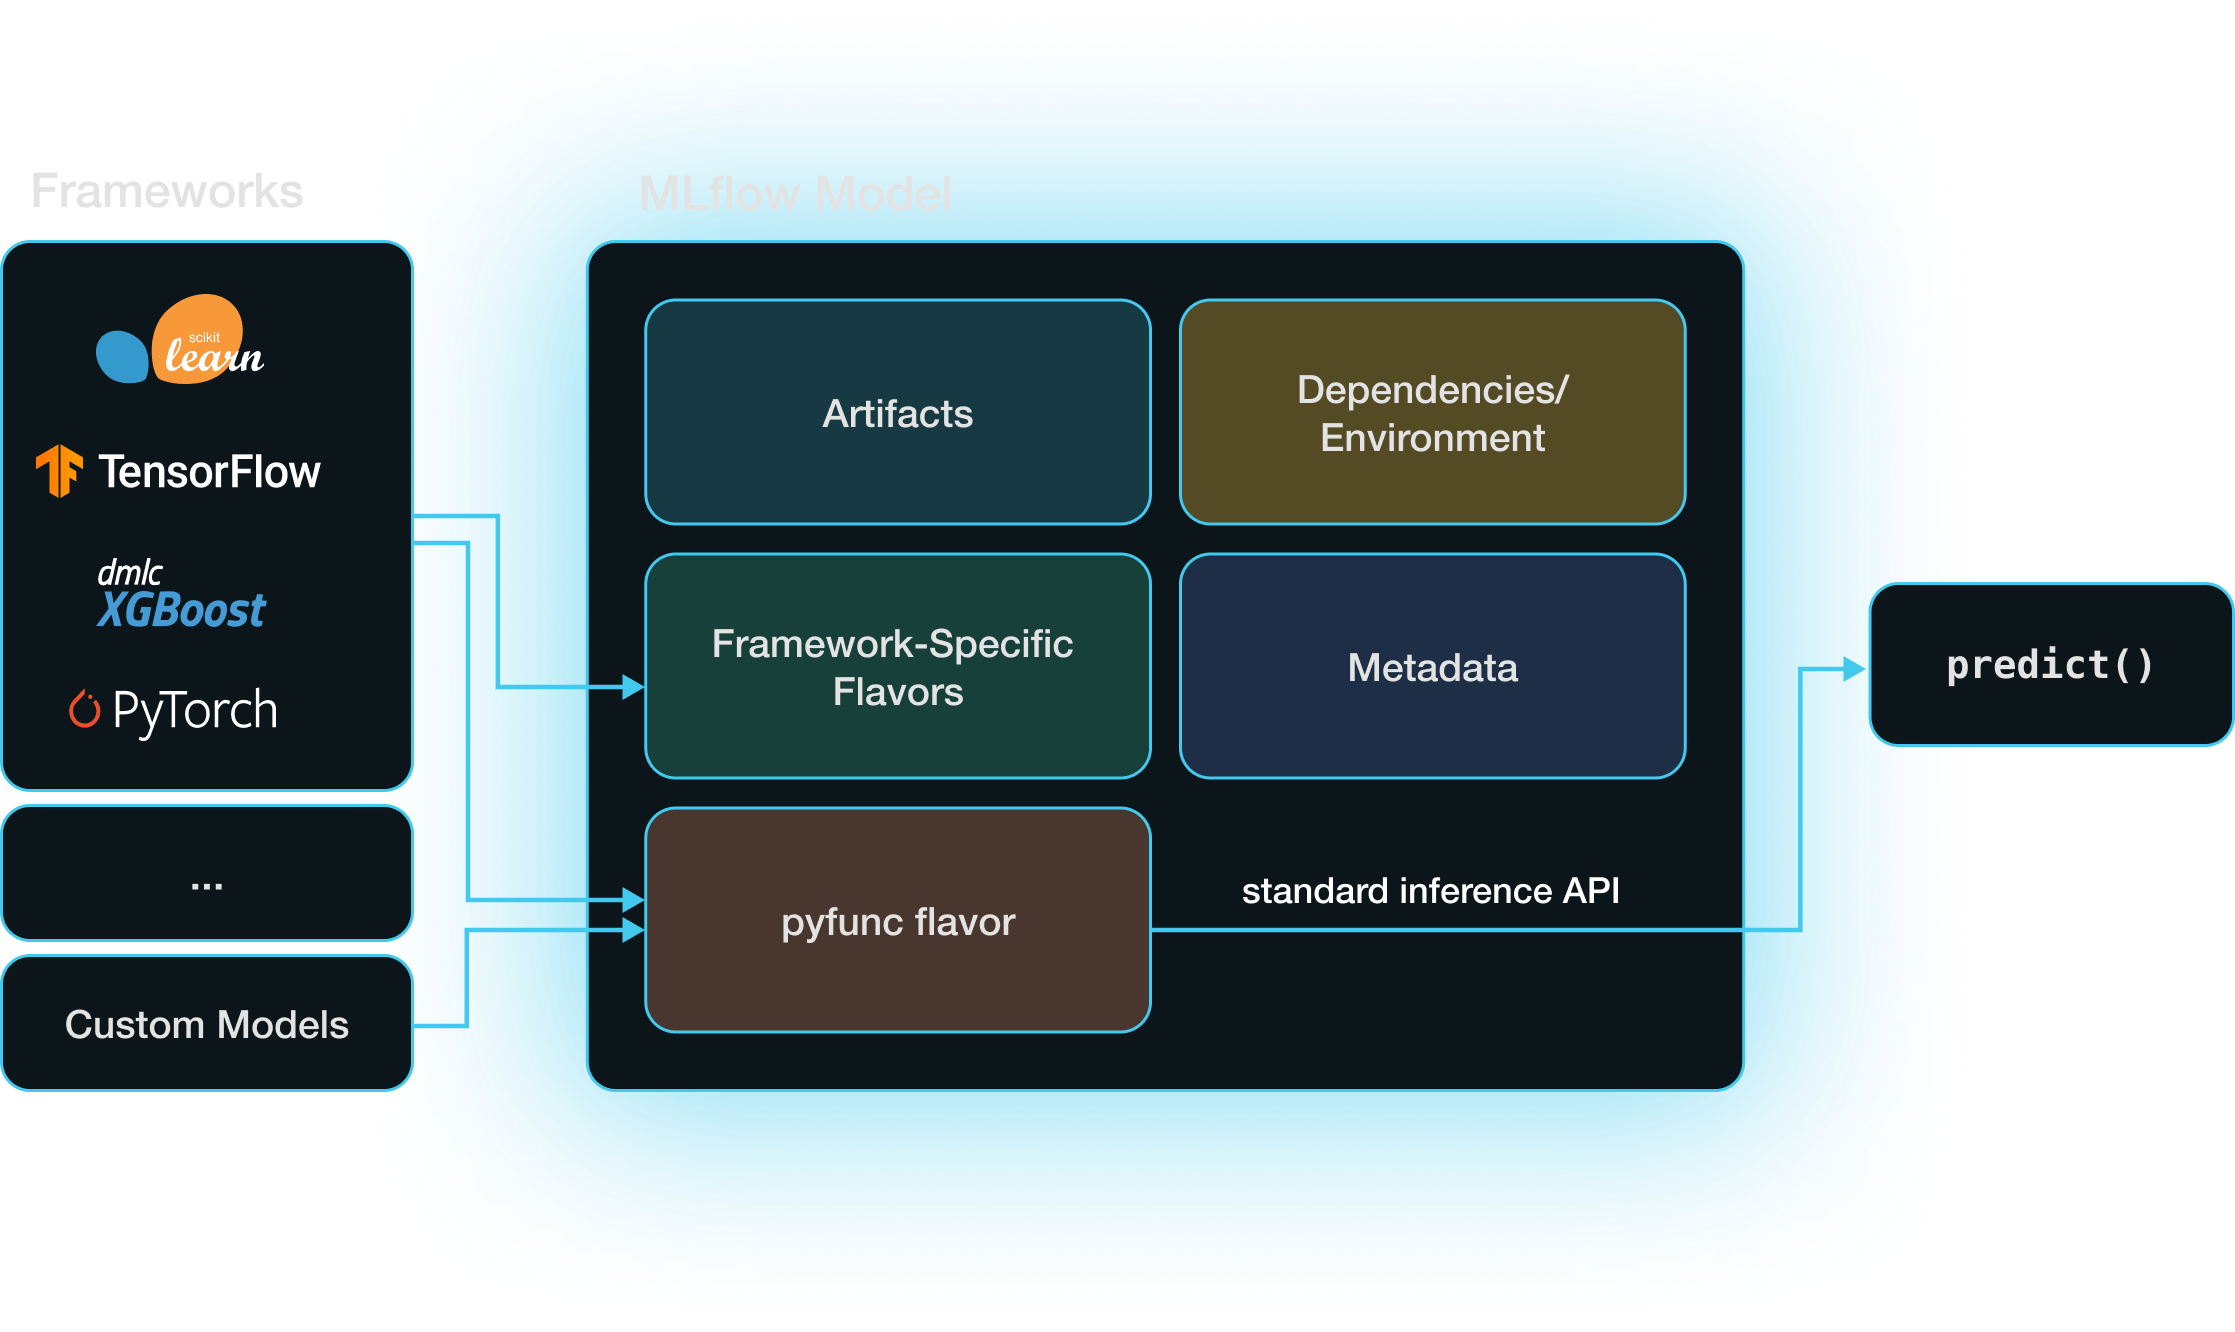


In [6]:
import json

import requests

payload3 = json.dumps(
    {
        "inputs": [
            {
                "island": "Biscoe",
                "culmen_length_mm": 48.6,
                "culmen_depth_mm": 16.0,
                "flipper_length_mm": 230.0,
                "body_mass_g": 5800.0,
                "sex": "MALE",
            },
            {
                "island": "Torgersen",
                "culmen_length_mm": 44.1,
                "culmen_depth_mm": 18.0,
                "flipper_length_mm": 210.0,
                "body_mass_g": 4000,
                "sex": "FEMALE",
            },
            {
                "island": "Torgersen",
                "culmen_length_mm": 39.1,
                "culmen_depth_mm": 18.7,
                "flipper_length_mm": 181.0,
                "body_mass_g": 3750,
                "sex": "MALE",
            },
        ],
    },
)

response = requests.post(
    url="http://127.0.0.1:9876/invocations",
    headers={"Content-Type": "application/json"},
    data=payload3,
)
print(response.json())

{'predictions': [{'prediction': 'Gentoo', 'confidence': 0.9299716949462891}, {'prediction': 'Gentoo', 'confidence': 0.3634946644306183}, {'prediction': 'Adelie', 'confidence': 0.9896042346954346}]}


In [7]:
payload4 = json.dumps(
    {
        "inputs": [
            {
                "island": "Torgersen2",
                "culmen_length_mm": 39.1,
                "culmen_depth_mm": 18.7,
                "flipper_length_mm": 181.0,
                "body_mass_g": 3750,
                "sex": "MALE",
            },
        ],
    },
)

response = requests.post(
    url="http://127.0.0.1:9876/invocations",
    headers={"Content-Type": "application/json"},
    data=payload4,
)
print(response.json())

{'predictions': [{'prediction': 'Adelie', 'confidence': 0.9879838228225708}]}
